# **Clasificación y Optimización de Hiperparámetros (Core)**


**Objetivo:** Implementar un pipeline completo de machine learning para un problema de clasificación utilizando técnicas de preprocesamiento, modelado, y optimización de hiperparámetros. Enfocar especialmente en la limpieza de datos y la optimización utilizando GridSearchCV y RandomizedSearchCV.

**Instrucciones:**

**!. Carga y Exploración Inicial de Datos:**

* Cargar el dataset desde Kaggle.
* Realizar una exploración inicial para entender la estructura del dataset y las características disponibles.

* Identificar y documentar los valores faltantes y outliers en el dataset.

In [27]:
# Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix


In [1]:
# Cargamos el dataset
path = 'C:/Users/damav/Desktop/Codingdojo/clases/machine-learning/data/insurance.csv'

df = pd.read_csv(path)
df.head()

NameError: name 'pd' is not defined

In [3]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 1


In [ ]:
# Verificamos los valores faltantes
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

# No hay valores nulos

,datos sin NAs en q,Na en q,Na en %
age,1338,0,0.0
sex,1338,0,0.0
bmi,1338,0,0.0
children,1338,0,0.0
smoker,1338,0,0.0
region,1338,0,0.0
charges,1338,0,0.0


In [6]:
# Información del dataset, no hay necesidad de convertir los datos. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
# Convertimos los datos a booleanos

# Convertir las columnas 'sex' y 'region' a categoricas
df['sex'] = df['sex'].astype('category')
df['region'] = df['region'].astype('category')

# Convertir las columnas 'smoker' y 'children' a booleanas
df['smoker'] = df['smoker'].replace({'yes': True, 'no': False})
df['smoker'] = df['smoker'].astype(bool)

print(df.dtypes)


age            int64
sex         category
bmi          float64
children       int64
smoker          bool
region      category
charges      float64
dtype: object


In [ ]:
df.describe()

# STD en rango normales, menos para Charges.

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


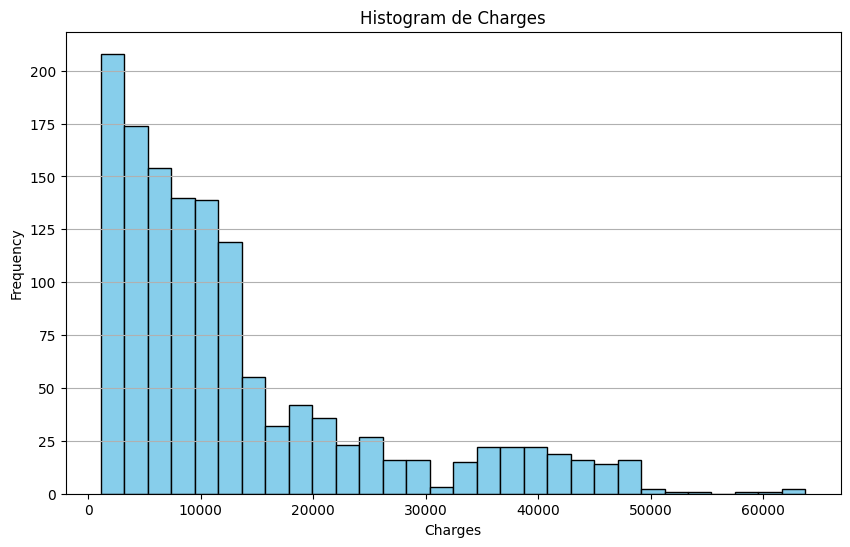

In [12]:
# Histograma de charges
plt.figure(figsize=(10, 6))
plt.hist(df['charges'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram de Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

# Podemos observar valores menos frecuetnes de 50000 para arribe. Sin embargo, el corgos mas alto podrian estar relacionciados a la edad, condiciones preexistentes, etc.

## **2. Preprocesamiento de Datos:**

* Imputar valores faltantes utilizando técnicas adecuadas (media, mediana, moda, imputación avanzada).

* Codificar variables categóricas utilizando One-Hot Encoding.

* Escalar características numéricas utilizando StandardScaler.

No hay valores faltantes para imputar

In [19]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Create the target variable
df_encoded['high_charge'] = (df_encoded['charges'] > df_encoded['charges'].median()).astype(int)

# Verificamos las columnas
y_counts = df_encoded['high_charge'].value_counts()
print("Counts of each class:")
print(y_counts)

# Removemos la clase minoritaria
if (y_counts < 2).any():
    
    valid_classes = y_counts[y_counts > 1].index  
    df_filtered = df_encoded[df_encoded['high_charge'].isin(valid_classes)]

    # Definimos X e y
    X = df_filtered.drop(['charges', 'high_charge'], axis=1)
    y = df_filtered['high_charge']
else:
    # Definimos X e y si las clases eran validad
    X = df_encoded.drop(['charges', 'high_charge'], axis=1)
    y = df_encoded['high_charge']

# Inciamos StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertimos a dataframe
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

Counts of each class:
high_charge
1    669
0    669
Name: count, dtype: int64


## **3.Implementación de Modelos de Clasificación:**

* Entrenar y evaluar al menos tres modelos de clasificación diferentes: Regresión Logística, K-Nearest Neighbors (KNN), y Árbol de Decisión.

* Utilizar validación cruzada para evaluar el rendimiento inicial de los modelos.


In [21]:
# Dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Definimos los modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} mean cross-validation accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Entrenamos los modelos 
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Imprimimos el reporte
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Logistic Regression mean cross-validation accuracy: 0.9047 ± 0.0163
K-Nearest Neighbors mean cross-validation accuracy: 0.8776 ± 0.0186
Decision Tree mean cross-validation accuracy: 0.8757 ± 0.0228

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       146
           1       0.89      0.93      0.91       122

    accuracy                           0.91       268
   macro avg       0.91      0.92      0.91       268
weighted avg       0.92      0.91      0.91       268

Accuracy: 0.9142

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       146
           1       0.88      0.92      0.90       122

    accuracy                           0.90       268
   macro avg       0.90      0.90      0.90       268
weighted avg       0.90      0.90      0.90       268

Accuracy: 0.9030

Decision Tree Classificat

## **4. Optimización de Hiperparámetros:**

* Implementar GridSearchCV para optimizar los hiperparámetros de los modelos seleccionados.

* Implementar RandomizedSearchCV como método alternativo de optimización.

* Comparar los resultados de GridSearchCV y RandomizedSearchCV para los modelos optimizados.


In [ ]:
# Definimos los parametrod para Grid
param_grid_lr = {
    'C': np.logspace(-4, 4, 20),  
    'solver': ['liblinear', 'saga']  
}

param_grid_knn = {
    'n_neighbors': range(1, 31),  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}

param_grid_dt = {
    'max_depth': [None] + list(range(1, 21)),  
    'min_samples_split': [2] + list(range(3, 21)),  
    'min_samples_leaf': [1] + list(range(2, 21))  
}

In [ ]:
# Initializamos los modelos 
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), param_grid_lr),
    'K-Nearest Neighbors': (KNeighborsClassifier(), param_grid_knn),
    'Decision Tree': (DecisionTreeClassifier(), param_grid_dt)
}

# GridSearchCV 
grid_results = {}

for name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Guardamos los resultados
    grid_results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_estimator': grid_search.best_estimator_
    }

print("GridSearchCV Results:")
for name, result in grid_results.items():
    print(f"{name} Best Params: {result['best_params']}, Best Score: {result['best_score']:.4f}")


# Vemos que GridSeach tiene un ligeron mejor resultado

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 7980 candidates, totalling 39900 fits
GridSearchCV Results:
Logistic Regression Best Params: {'C': np.float64(0.23357214690901212), 'solver': 'liblinear'}, Best Score: 0.9047
K-Nearest Neighbors Best Params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}, Best Score: 0.9056
Decision Tree Best Params: {'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 2}, Best Score: 0.9290


In [25]:
# RandomizedSearchCV results
random_results = {}

for name, (model, params) in models.items():
    randomized_search = RandomizedSearchCV(model, param_distributions=params, n_iter=50,cv=5, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
    randomized_search.fit(X_train, y_train)
    
    # Store the results
    random_results[name] = {
        'best_params': randomized_search.best_params_,
        'best_score': randomized_search.best_score_,
        'best_estimator': randomized_search.best_estimator_
    }

print("\nRandomizedSearchCV Results:")
for name, result in random_results.items():
    print(f"{name} Best Params: {result['best_params']}, Best Score: {result['best_score']:.4f}")

c:\Users\damav\Desktop\Codingdojo\clases\machine-learning\notebook\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\damav\Desktop\Codingdojo\clases\machine-learning\notebook\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 50 candidates, totalling 250 fits

RandomizedSearchCV Results:
Logistic Regression Best Params: {'solver': 'liblinear', 'C': np.float64(0.23357214690901212)}, Best Score: 0.9047
K-Nearest Neighbors Best Params: {'weights': 'distance', 'n_neighbors': 24, 'metric': 'manhattan'}, Best Score: 0.9009
Decision Tree Best Params: {'min_samples_split': 18, 'min_samples_leaf': 6, 'max_depth': 6}, Best Score: 0.9243


## **5. Evaluación de Modelos:**

* Evaluar los modelos optimizados utilizando métricas de rendimiento como exactitud, precisión, recall, F1-Score y ROC-AUC.

* Generar y analizar la matriz de confusión para los modelos optimizados.

* Crear y visualizar la curva ROC para evaluar la capacidad del modelo para distinguir entre clases.


Logistic Regression Performance Metrics:
Accuracy: 0.9104
Precision: 0.8828
Recall: 0.9262
F1 Score: 0.9040
ROC AUC: 0.9589


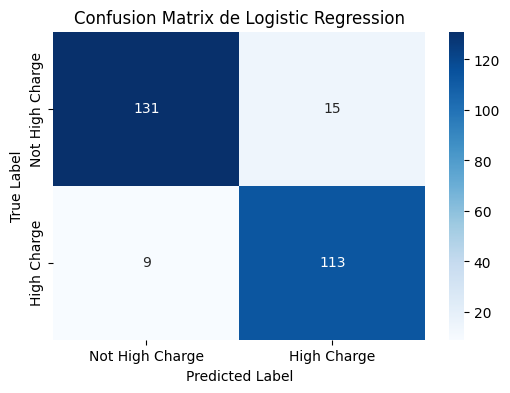

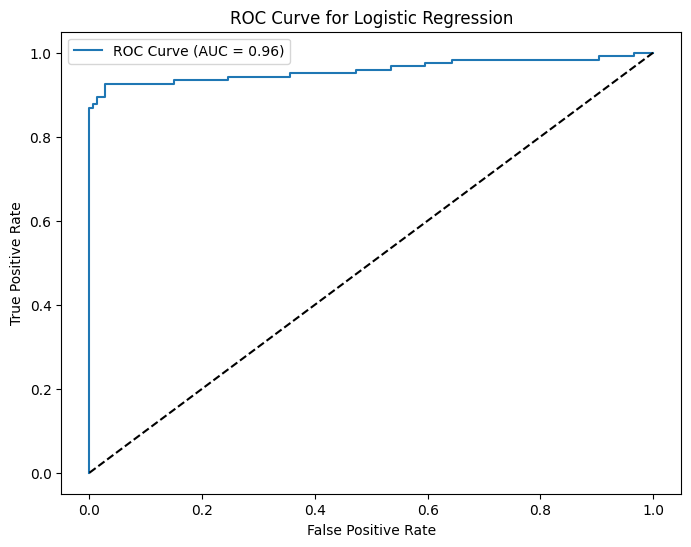


K-Nearest Neighbors Performance Metrics:
Accuracy: 0.9254
Precision: 0.9113
Recall: 0.9262
F1 Score: 0.9187
ROC AUC: 0.9506


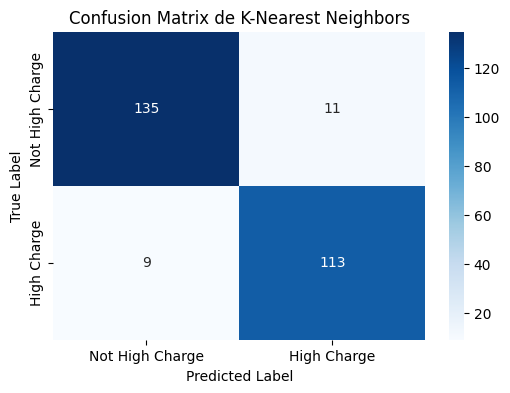

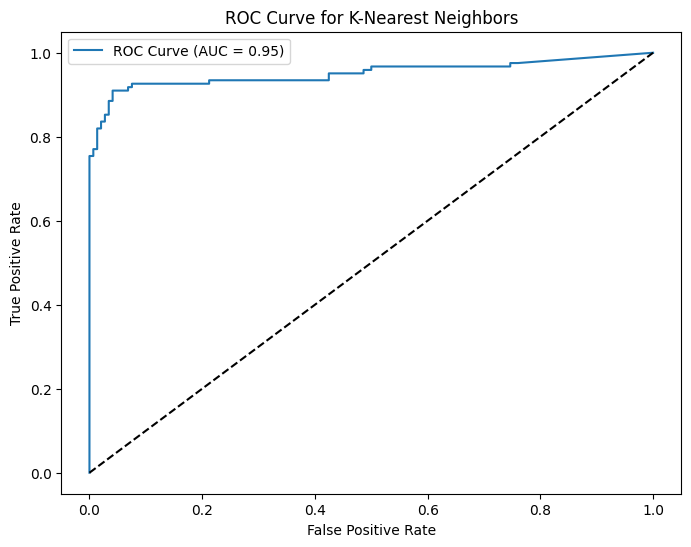


Decision Tree Performance Metrics:
Accuracy: 0.9254
Precision: 0.9474
Recall: 0.8852
F1 Score: 0.9153
ROC AUC: 0.9534


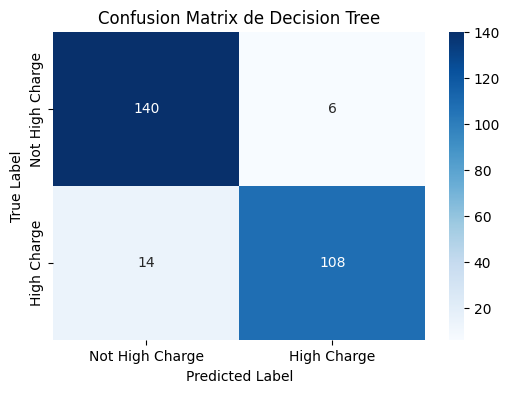

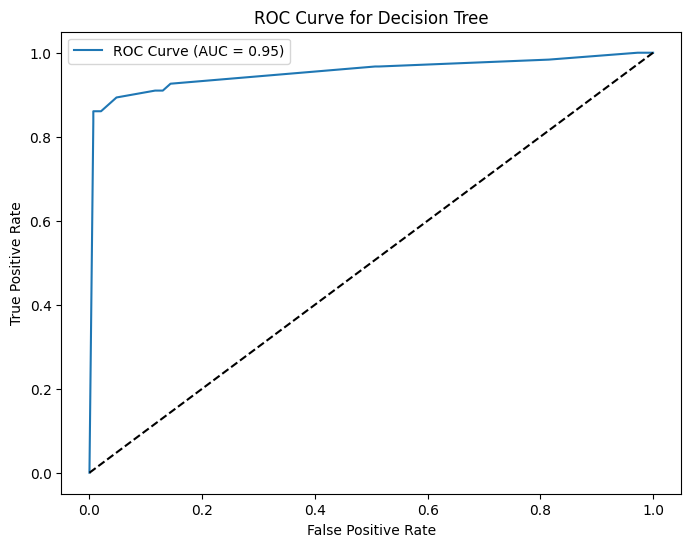

In [28]:
#  Evaluamos los modelos
for name, model_info in grid_results.items():
    model = model_info['best_estimator']
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  

    # Metricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    # Resultados
    print(f"\n{ name } Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not High Charge', 'High Charge'], 
                yticklabels=['Not High Charge', 'High Charge'])
    plt.title(f'Confusion Matrix de {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title(f'ROC Curve for {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()